Importing necessary modules

In [1]:
import math
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

Defining the Grover oracle

In [2]:
def grover_oracle(states):
    if not isinstance(states, list):
        states = [states]

    num_qubits = len(states[0])
    qc = QuantumCircuit(num_qubits)

    for target in states:
        rev_target = target[::-1]
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)

        qc.barrier()
    return qc

Creating Grover oracle for 10011, 01010

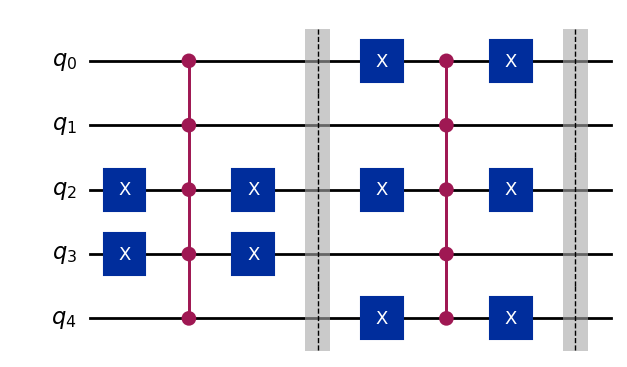

In [3]:
marked_states = ["10011", "01010"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

Creating the Grover operator

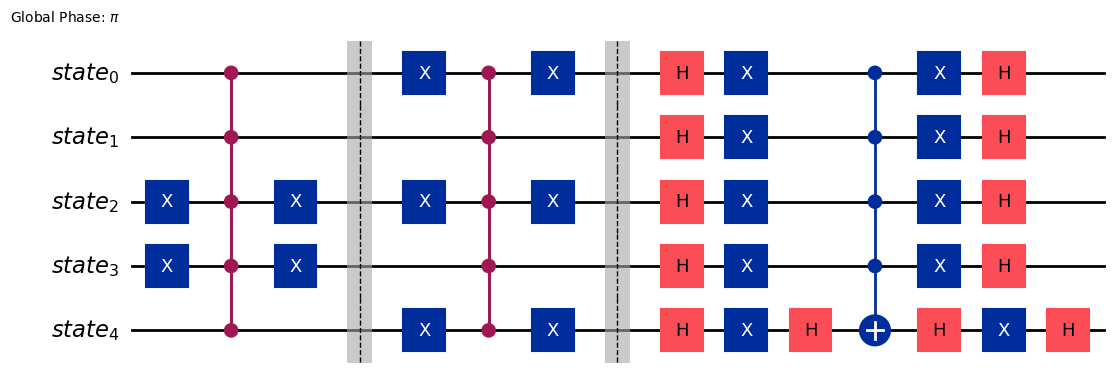

In [4]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

Optimal number of iterations of Grover operation

In [5]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

Quantum Circuit

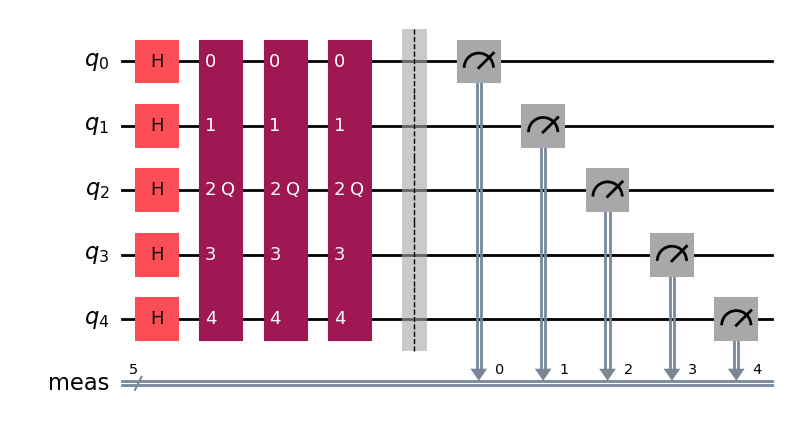

In [6]:
qc = QuantumCircuit(grover_op.num_qubits)

qc.h(range(grover_op.num_qubits))
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)

qc.measure_all()
qc.draw(output="mpl", style="iqp")

Running the circuit with SamplerV2

In [7]:
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=2)
isa_circuit = pm.run(qc)
with Session(backend=aer_sim) as session:
    sampler = Sampler(mode=session)
    result = sampler.run([isa_circuit]).result()

Plotting the results:

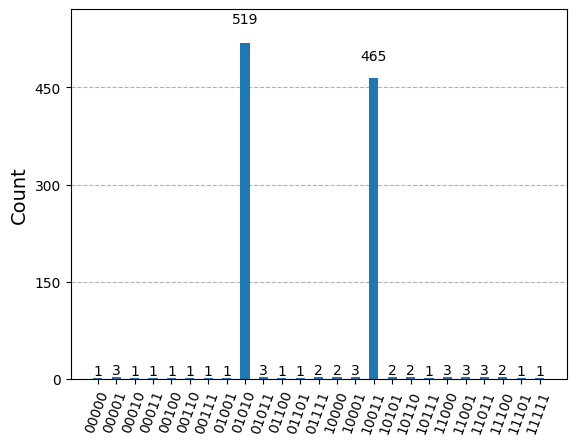

In [8]:
outputs = result[0].data.meas
counts = outputs.get_counts()

display(plot_histogram(counts))